# Face mask detection

Here I am going to detect whether a person is wearing mask or not. I am focussing on only two classes that are 'face_with_mask' and face_no_mask'.

## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Loading datasets

In [5]:
directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

In [6]:
print(len(df))
df.head()

15412


,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [7]:
print(len(df_test))
df_test.head()

8142


,name,x1,x2,y1,y2,classname
0,1800.jpg,NaN,NaN,NaN,NaN,NaN
1,1800.jpg,NaN,NaN,NaN,NaN,NaN
2,1800.jpg,NaN,NaN,NaN,NaN,NaN
3,1799.jpg,NaN,NaN,NaN,NaN,NaN
4,1799.jpg,NaN,NaN,NaN,NaN,NaN


# What is SSD?
SSD is Single Shot Multibox Detector. It is a technique that is used to detect objects in images using a single deep neural network. Basically its used for object detection in an image. By using a base architecture of VGG-16 Architecture, SSD is able to out perform other object detectors like YOLO and Faster R-CNN in both speed and accuracy. The architecture of SSD is given in the figure below. Training a SSD model from scratch will require a lot of data, so here I have imported pretrained weights (Caffe Face Detector Model) using OpenCV.

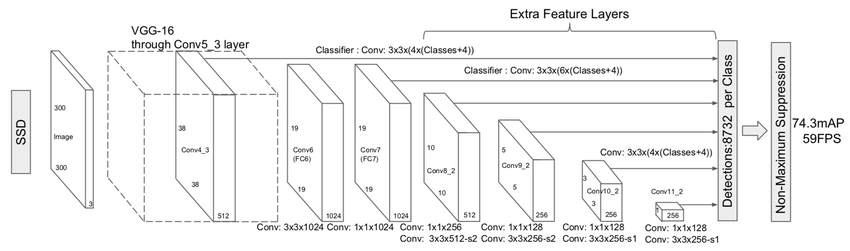

In [33]:
cvNet = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

creating helper functons:
1. The getJSON function retrieves the json file containing the bounding box data in the training dataset.
2. The adjust_gamma function is a non-linear operation used to encode and decode luminance or tristimulus values in video or still image systems. Simply put, it is used to instil a little bit of light into the image. If gamma <1, the image will shift to the darker end of the spectrum and when gamma> 1, there will be more light in the image.

In [10]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Data Processing
Exploring the JSON data provided for the training:

In [11]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}

The Annotations field contains the data of all the faces present in a particular image.
There are different class names, but the real class names are face_with_mask and face_no_mask.

Using the mask and the non_mask labels, the bounding box data of the json files is extracted. The faces of a particular image are extracted and stored in the data list with its tag for the learning process.

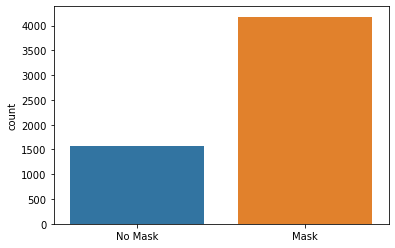

In [12]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

The visualization above tells us that the number of mask images> Number of images without a mask, so this is an unbalanced dataset. But since we’re using a pre-trained SSD model, which is trained to detect unmasked faces, this imbalance wouldn’t matter much.

In [13]:
#reshape the data before training a neural network:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

# Training Neural Network

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 460800)           

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [20]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=30,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/30
143/143 [==============================] - 497s 3s/step - loss: 0.2533 - accuracy: 0.8931 - val_loss: 0.2196 - val_accuracy: 0.9174
Epoch 2/30
143/143 [==============================] - 486s 3s/step - loss: 0.2320 - accuracy: 0.9102 - val_loss: 0.2038 - val_accuracy: 0.9209
Epoch 3/30
143/143 [==============================] - 498s 3s/step - loss: 0.2228 - accuracy: 0.9148 - val_loss: 0.2376 - val_accuracy: 0.9122
Epoch 4/30
143/143 [==============================] - 487s 3s/step - loss: 0.2030 - accuracy: 0.9229 - val_loss: 0.1894 - val_accuracy: 0.9348
Epoch 5/30
143/143 [==============================] - 484s 3s/step - loss: 0.1768 - accuracy: 0.9310 - val_loss: 0.2392 - val_accuracy: 0.9226
Epoch 6/30
143/143 [==============================] - 487s 3s/step - loss: 0.1778 - accuracy: 0.9265 - val_loss: 0.2333 - val_accuracy: 0.9400
Epoch 7/30
143/143 [==============================] - 487s 3s/step - loss: 0.1679 - accuracy: 0.9365 - val_loss: 0.2013 - val_accuracy: 0.9383

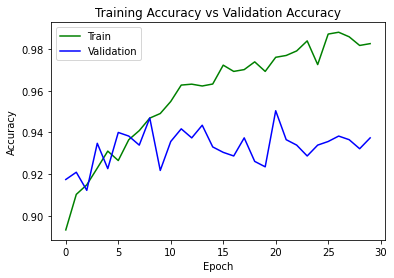

In [36]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

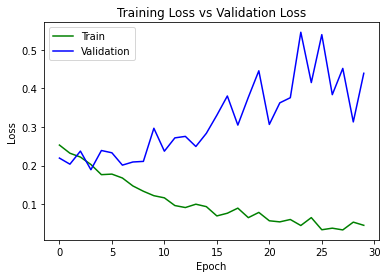

In [37]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

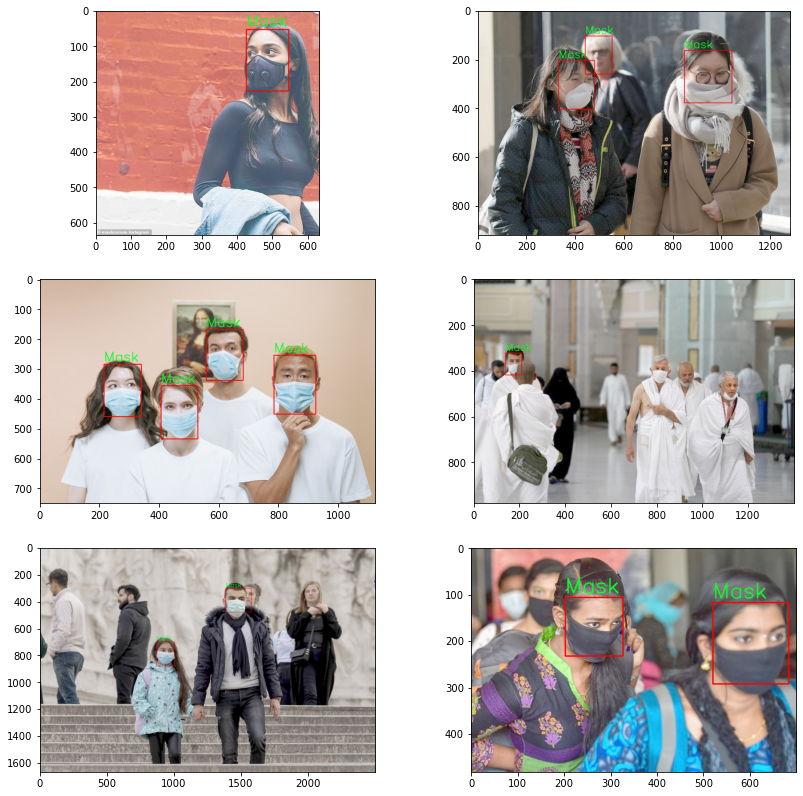

In [38]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Conclusion
By analyzing the results it can be observed that the whole system works well for faces that have spatial dominance i.e. in image at (1,1), (1,2) and (2,1) but fails in case of (2,2) where the faces are small and occupy less space in the overall image.